## Intro
This code shows an example of using OWAD upon **normal-confidence** anomaly detection models. Here we use a Log Anomaly Detection case with `DeepLog` (aka LSTM) as the anomaly detection model and `BGL` as the log dataset.


In [1]:
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/admodels/DeepLog.py
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/moudles/calibrator.py
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/moudles/shifthunter.py
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/myutils.py
!wget https://raw.githubusercontent.com/figaz123/OWAD/main/configs.yml

--2024-03-28 13:11:26--  https://raw.githubusercontent.com/figaz123/OWAD/main/admodels/DeepLog.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5484 (5.4K) [text/plain]
Saving to: ‘DeepLog.py’

DeepLog.py          100%[===================>]   5.36K  --.-KB/s    in 0s      

2024-03-28 13:11:26 (35.2 MB/s) - ‘DeepLog.py’ saved [5484/5484]

--2024-03-28 13:11:27--  https://raw.githubusercontent.com/figaz123/OWAD/main/moudles/calibrator.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4332 (4.2K) [text/plain]
Saving to: ‘calibrat

In [3]:
%load_ext autoreload
%autoreload 2
## import packages
import sys
# sys.path.append('../admodels/')
# sys.path.append('../moudles/')
# sys.path.append('../baselines/')
# sys.path.append('../')
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import _pickle as pkl
import DeepLog
from calibrator import Calibrator
from shifthunter import ShiftHunter
import myutils as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Load control and treatment data
con_seq = np.load('/content/logad_con.npz')
X_ic, X_oc, y_c = con_seq['input'], con_seq['output'], con_seq['label']
tre_seq = np.load('/content/logad_tre.npz')
X_it, X_ot, y_t = tre_seq['input'], tre_seq['output'], tre_seq['label']

## Prepare AD model and data

In [6]:
# training DeepLog model
utils.set_random_seed()
train_num = 100000
X_train = {'input':X_ic[y_c==0][:train_num], 'output':X_oc[y_c==0][:train_num]}
model = DeepLog.train(X_train)

Epoch [1/20], train_loss: 3.1407
Epoch [2/20], train_loss: 1.3234
Epoch [3/20], train_loss: 1.0445
Epoch [4/20], train_loss: 0.7898
Epoch [5/20], train_loss: 0.6322
Epoch [6/20], train_loss: 0.4210
Epoch [7/20], train_loss: 0.3273
Epoch [8/20], train_loss: 0.2751
Epoch [9/20], train_loss: 0.2357
Epoch [10/20], train_loss: 0.2069
Epoch [11/20], train_loss: 0.1878
Epoch [12/20], train_loss: 0.1753
Epoch [13/20], train_loss: 0.1659
Epoch [14/20], train_loss: 0.1581
Epoch [15/20], train_loss: 0.1525
Epoch [16/20], train_loss: 0.1474
Epoch [17/20], train_loss: 0.1426
Epoch [18/20], train_loss: 0.1397
Epoch [19/20], train_loss: 0.1366
Epoch [20/20], train_loss: 0.1332
Finished Training


In [7]:
## test performance at control set and treament set (testing data)
pred_con, prob_con = DeepLog.test(model, {'input':X_ic, 'output':X_oc})
print('Test in Control set:')
print('f1-score:', metrics.f1_score(y_c, pred_con),
      'precision:', metrics.precision_score(y_c, pred_con),
      'recall:', metrics.recall_score(y_c, pred_con)
     )

pred_tre, prob_tre = DeepLog.test(model, {'input':X_it, 'output':X_ot})
print('Test in Treatment set:')
print('f1-score:', metrics.f1_score(y_t, pred_tre),
      'precision:', metrics.precision_score(y_t, pred_tre),
      'recall:', metrics.recall_score(y_t, pred_tre)
     )

Test in Control set:
f1-score: 0.8986315255955398 precision: 0.8961334344200151 recall: 0.901143583227446
Test in Treatment set:
f1-score: 0.448512585812357 precision: 0.298679309177108 recall: 0.9


**(As we can see that, the performance decreases sharply from 0.89 to 0.44)**

In [8]:
## get validation data of control set and treament set
vali_num = 100000
X_con, y_con = {'input':X_ic[:vali_num], 'output':X_oc[:vali_num]}, y_c[:vali_num]
X_tre, y_tre = {'input':X_it[:vali_num], 'output':X_ot[:vali_num]}, y_t[:vali_num]
prob_con = prob_con[:vali_num]
prob_tre = prob_tre[:vali_num]

## Let's use OWAD！

NOTICE: Initialize OWAD Calibrator Under **Isotonic** Method!
NOTICE: uncalibrated Probs is **BENIGN** confidence
NOTICE: Initilize OWAD Shift Handler Under **Seq** Mode!
Non-shift, p_value: 0.06293706293706294
Non-shift, skip explain and adaptation!
Visualize Shift:


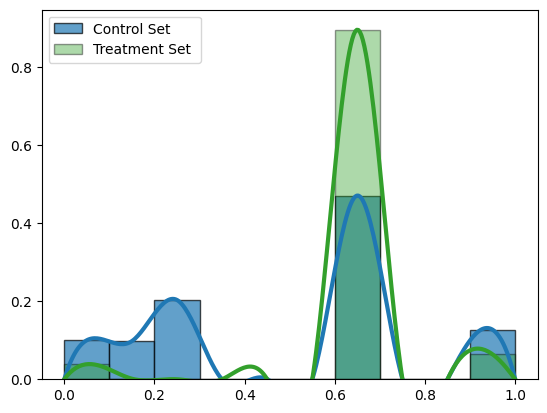

In [9]:
utils.set_random_seed()

## detect shift with OWAD
cb = Calibrator(X_con, method='Isotonic')
cb.set_calibrator(prob_con, is_P_mal=False)
sh = ShiftHunter(prob_con, prob_tre, cb, ad_type='Seq')
t = utils.get_params('ShiftDetector')['test_thres']
p_value = sh.permu_test()
if p_value >= t:
    print("Non-shift, p_value:", p_value)
    print("Non-shift, skip explain and adaptation!")
else:
    print('Shift! P-value is', p_value)
print("Visualize Shift:")
sh.visualize_hists()

In [10]:
utils.set_random_seed()

## explain and adapt to shift with OWAD
ohd_bgt = 30000
exp_result = sh.explainer(X_tre, y_tre, label_num = ohd_bgt) # , auto_cali_thres=True
sh.adapter(model)

step:0 |Loss:16.0000 |Accuracy_Loss:1.0000 |Overhead_Loss:1.0000 |Determinism_Loss:1.0000 |M_c num: 50165 |M_t num: 50066
step:10 |Loss:15.5985 |Accuracy_Loss:0.9401 |Overhead_Loss:0.9884 |Determinism_Loss:1.0144 |M_c num: 49710 |M_t num: 49562
step:20 |Loss:15.2262 |Accuracy_Loss:0.8855 |Overhead_Loss:0.9774 |Determinism_Loss:1.0248 |M_c num: 49265 |M_t num: 48933
step:30 |Loss:14.8671 |Accuracy_Loss:0.8328 |Overhead_Loss:0.9671 |Determinism_Loss:1.0321 |M_c num: 48787 |M_t num: 48193
step:40 |Loss:14.5207 |Accuracy_Loss:0.7816 |Overhead_Loss:0.9576 |Determinism_Loss:1.0364 |M_c num: 48404 |M_t num: 47349
step:49 |Loss:14.2178 |Accuracy_Loss:0.7364 |Overhead_Loss:0.9498 |Determinism_Loss:1.0379 |M_c num: 48078 |M_t num: 46529
get X_c, X_t (len): 100000 100000
** Cliping <remain_X_t> ...
NOTICE: simulating labelling...
Filter 11 anomalies in remain_X_tre
Remain X_c, X_t (len): 51938 29989
Adapter: Begin Processing ... 
Estimating Params Weight:0/8193
Estimating Params Weight:1000/8193


In [11]:
## Test the performance after OWAD adaptation
print('After OWAD Adaptation:')
pred_tre, prob_tre = DeepLog.test(sh.model, {'input':X_it, 'output':X_ot})
print('f1-score:', metrics.f1_score(y_t, pred_tre),
      'precision:', metrics.precision_score(y_t, pred_tre),
      'recall:', metrics.recall_score(y_t, pred_tre)
     )

After OWAD Adaptation:
f1-score: 0.8 precision: 0.7226337448559671 recall: 0.8959183673469387


**(As we can see that, OWAD Adaptation significantly improves the performance of AD models from 0.44 to 0.78 with 30k labels, which is 30% of validation set and 15% of testing set)**

### Compared with retraining

In [12]:
utils.set_random_seed()

## retraining with all old samples and `ohd_bgt` new samples
X_retrain = {'input': np.concatenate((X_ic[y_c==0][:train_num], X_tre['input'][:ohd_bgt])),
             'output': np.concatenate((X_oc[y_c==0][:train_num], X_tre['output'][:ohd_bgt]))}
retrain_model = DeepLog.train(X_retrain)

## test the performance of retraining model
pred_tre, prob_tre = DeepLog.test(retrain_model, {'input':X_it, 'output':X_ot})
print('After Retraining:')
print('f1-score:', metrics.f1_score(y_t, pred_tre),
      'precision:', metrics.precision_score(y_t, pred_tre),
      'recall:', metrics.recall_score(y_t, pred_tre)
     )

Epoch [1/20], train_loss: 2.4087
Epoch [2/20], train_loss: 0.7089
Epoch [3/20], train_loss: 0.5786
Epoch [4/20], train_loss: 0.3888
Epoch [5/20], train_loss: 0.2321
Epoch [6/20], train_loss: 0.1784
Epoch [7/20], train_loss: 0.1514
Epoch [8/20], train_loss: 0.1459
Epoch [9/20], train_loss: 0.1335
Epoch [10/20], train_loss: 0.1290
Epoch [11/20], train_loss: 0.1270
Epoch [12/20], train_loss: 0.1177
Epoch [13/20], train_loss: 0.1137
Epoch [14/20], train_loss: 0.1103
Epoch [15/20], train_loss: 0.1070
Epoch [16/20], train_loss: 0.1045
Epoch [17/20], train_loss: 0.1018
Epoch [18/20], train_loss: 0.0996
Epoch [19/20], train_loss: 0.0974
Epoch [20/20], train_loss: 0.0957
Finished Training
After Retraining:
f1-score: 0.5420443888715224 precision: 0.3907165389815232 recall: 0.8846938775510204


**The result shows that retraining fails to improve the performance in this case.**